## **Example. Estimating a population total under simple random sampling using transformed normal models**

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

import random
# from scipy.optimize import fsolve, root
import statistics as stat
from scipy import stats
import math

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

List of populations of cities and towns in New York State in 1960,
used in the first example of Section 7.6 and summarized in Table 7.2
of Bayesian Data Analysis.  Code = 400 if included in Sample 1 only; 300 if
included in Sample 2 only; 200 if included in both samples; 100 if
included in neither sample.

In [4]:
new_york = np.genfromtxt('data/newyork.txt', skip_header=7, dtype=(int, int))
print(new_york.shape)

(804, 2)


Let's find the sample 1 and sample 2.

In [5]:
sample1 = []
sample2 = []

for i, j in new_york[:, :]:
    if j == 400 or j == 200:
        sample1.append(i)
    if j == 300 or j == 200:
        sample2.append(i)
        
sample1.sort()
sample2.sort()

As you may see, the lenght of `sample2` is 104.

In [6]:
print(len(sample2))

104


I delete five entries and I insert a new datum in order to get the mean and the standard deviation right.

In [7]:
sample2.sort()
inds = [1, 2, 3, 4, 5]
for i in sorted(inds, reverse=True):
    del sample2[i]
    
sample2.append(1425350)

In [14]:
print('The mean is {}'.format(stat.mean(sample2)))
print('The standard deviation is {}'.format(int(stat.stdev(sample2))))
print('The lenght is {}'.format(len(sample2)))

The mean is 38176
The standard deviation is 228625
The lenght is 100


#### **Sample1: initial analysis.**

In [21]:
def logp_(value):
    return tt.log(tt.pow(value, -1))

with pm.Model() as model_1:
    mu = pm.Uniform('mu', lower=-5e5, upper=5e5)
    sigma = pm.Uniform('sigma', lower=0, upper=5e5)
    pm.Potential('sigma_log', logp_(sigma))
    y_bar = pm.Normal('y_bar', mu=mu, sd=sigma, observed=sample1)

In [22]:
with model_1:
    trace_1 = pm.sample(draws=2_000, tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2755.58draws/s]


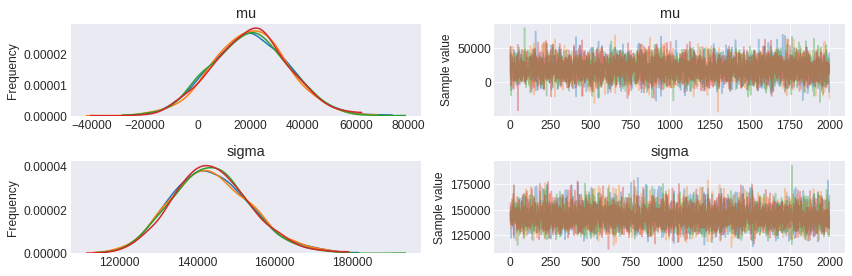

In [23]:
pm.traceplot(trace_1, varnames=['mu', 'sigma']);

In [24]:
df = pm.summary(trace_1, varnames=['mu', 'sigma'])
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,19710.108315,14268.971974,168.24515,-8670.930866,46659.305532,7564.838706,0.999851
sigma,143578.599210,10083.027261,116.25791,124897.229129,164214.308903,7644.322681,0.999808


In [31]:
with model_1:
    ppc_1 = pm.sample_posterior_predictive(trace_1, samples=100, vars=[y_bar, mu, sigma])

100%|██████████| 100/100 [00:00<00:00, 1270.92it/s]


The goal is to find the $95\, \%$ posterior distribution for $y_{\text{total}}$. How? Remember the equation (7.18):

$$y_{\text{total}} = N \cdot \overline {y} = n\cdot \overline y_{\text{obs}} + (N − n) \overline y_{\text{mis}}.$$

We need to find $\overline y_{\text{mis}}$. Page 205 says how to find that value (I will try to follow it closely). 

With each `mu` and  each `sigma`, I use `np.random.normal` to obtain 100 values, then I get the mean of that array.

In [45]:
y_miss_1 = []

for i, j  in zip(ppc_1['mu'], ppc_1['sigma']):
    temp = np.random.normal(loc=i, scale=j, size=100)
    y_miss_1.append(np.mean(temp))
    
y_miss_1 = np.array(y_miss_1)
y_miss_1[40:50]

array([ 17039.62282033,  26720.41366363,   7518.52505453,  57730.94756086,
       -12852.93258913, -19622.63446994,  37368.65737889,  33366.29200805,
        23164.23888715,  32876.00758958])

Now, we find $y_{\text{total}}$. Since there are 100 values, we can find the posterior interval.

In [55]:
N = 804
n = 100
y_total = n * np.mean(ppc_1['y_bar'], axis=1) + (N - n) * y_miss_1
perc_25 = int(np.percentile(y_total, 2.5))
perc_975 = int(np.percentile(y_total, 97.5))
perc_25, perc_975

(-9309638, 45384477)

So the interval is $[-9.3 \times 10^6, 45.3 \times 10^6]$. The modified interval is $[1.9 \times 10^6, 45.3 \times 10^6]$

We repeat the above analysis under the assumption that the $N = 804$ values in the complete data follow a lognormal distribution.

In [59]:
with pm.Model() as model_1_log:
    mu = pm.Uniform('mu', lower=0, upper=5e2)
    sigma = pm.Uniform('sigma', lower=0, upper=5e2)
#     pm.Potential('simga_log', logp_(sigma))
    y_bar = pm.Lognormal('y_bar', mu=mu, sd=sigma, observed=sample1)

In [60]:
with model_1_log:
    trace_2 = pm.sample(draws=2000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2737.85draws/s]


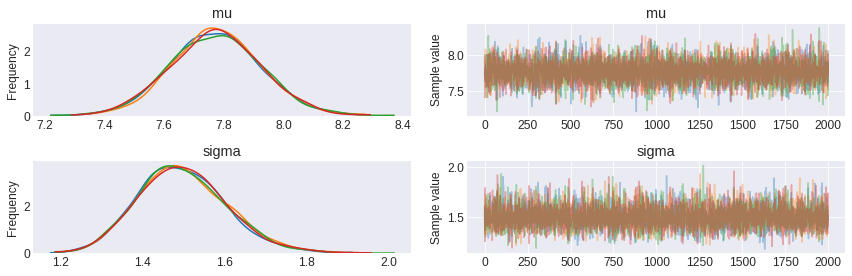

In [61]:
pm.traceplot(trace_2, varnames=['mu', 'sigma']);

In [62]:
df2 = pm.summary(trace_2, varnames=['mu', 'sigma'])
df2

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,7.771712,0.149943,0.001591,7.491939,8.082877,7751.228026,1.000008
sigma,1.496489,0.107192,0.001349,1.298233,1.711843,7766.669972,1.000063


In [63]:
with model_1_log:
    ppc_1_log = pm.sample_posterior_predictive(trace_2, samples=100, vars=[y_bar, mu, sigma])

100%|██████████| 100/100 [00:00<00:00, 1308.51it/s]


Again, we need to find the posterior interval for $y_{\text{total}}$. Pay attention to the code.

In [65]:
y_miss_2 = []

for i, j  in zip(ppc_1_log['mu'], ppc_1_log['sigma']):
    temp = np.exp(np.random.normal(loc=i, scale=j, size=100))
    y_miss_2.append(np.mean(temp))
    
y_miss_2 = np.array(y_miss_2)
y_miss_2[50:60]

array([10200.64290851, 11676.18673019,  6896.15696806,  6770.35775471,
        5859.87062347,  4490.13135326,  7300.05823096,  6443.34956636,
       13206.83712416, 13352.03118362])

In [66]:
y_total_2 = n * np.mean(ppc_1['y_bar'], axis=1) + (N - n) * y_miss_2
perc_25 = int(np.percentile(y_total_2, 2.5))
perc_975 = int(np.percentile(y_total_2, 97.5))
perc_25, perc_975

(3508456, 16297655)

So the interval is $[3.5 \times 10^6, 16.2 \times 10^6]$. 

#### **Sample 1: checking the lognormal model.**

In [72]:
cond = np.sum(ppc_1_log['y_bar'], axis=1) >= sum(sample1)
np.sum(cond)

0

0 of 100 has a greater sum than `sum(sample1)`. That number could change if you rerun this notebook.

#### **Sample 1: extended analysis.**

Using SciPy, I find $\phi$. The function `scipy.stats.boxcox` uses the maximum likelihood estimation, although it is knows to have [some issues](https://github.com/scipy/scipy/issues/6873). [This question](https://stats.stackexchange.com/questions/337527/parameter-lambda-of-box-cox-transformation-and-likelihood) explains it better and why it is used [here](https://stats.stackexchange.com/questions/202530/how-is-the-box-cox-transformation-valid).

In [73]:
from scipy import stats
stats.boxcox(sample1)

(array([3.4187599 , 3.43636137, 3.45779273, 3.59073266, 3.66518784,
        3.67873302, 3.69404323, 3.69974335, 3.74300032, 3.76764624,
        3.78622009, 3.79048268, 3.80776645, 3.85302718, 3.86185084,
        3.96220149, 3.96267437, 3.97196957, 3.97740298, 3.98229293,
        4.00634468, 4.01975659, 4.02281956, 4.03546794, 4.03943764,
        4.04264302, 4.04405558, 4.05475994, 4.0611168 , 4.0630934 ,
        4.0630934 , 4.08543718, 4.08933258, 4.10068572, 4.10909731,
        4.119908  , 4.1243701 , 4.12798805, 4.14391131, 4.14463408,
        4.17520648, 4.17690753, 4.20551459, 4.20870686, 4.22617121,
        4.23353249, 4.23754654, 4.24328409, 4.26108091, 4.29168367,
        4.29208022, 4.29987396, 4.3020359 , 4.30865048, 4.33092515,
        4.33731712, 4.3437468 , 4.36123055, 4.37230068, 4.381959  ,
        4.38249337, 4.38923941, 4.40545511, 4.41753983, 4.45292168,
        4.45636669, 4.46149302, 4.46346024, 4.46455878, 4.47518134,
        4.48038161, 4.51643507, 4.53091661, 4.54

So $\phi$ is $-0.1688902053661071$. 

In [124]:
phi = stats.boxcox(sample1)[1]

# An inverse Box-Cox transformation is needed    
def invbox_cox(data, phi):
    if phi == 0:
        return np.exp(data)
    else:
        return np.power(data * phi + 1, 1 / phi)
        
sample1 = np.array(sample1)

In [169]:
data_transformed = stats.boxcox(sample1)[0]

with pm.Model() as model_trans:
    mu = pm.Uniform('mu', lower=0, upper=1e2)
    sigma = pm.Uniform('sigma', lower=0, upper=5e1)
    y_phi = pm.Normal('y_phi', mu=mu, sd=sigma, observed=data_transformed)

In [90]:
with model_trans:
    trace_3 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2550.28draws/s]


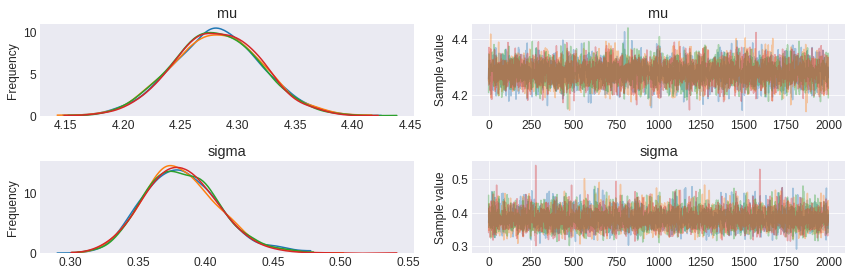

In [91]:
pm.traceplot(trace_3);

In [92]:
pm.summary(trace_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.281229,0.037810,0.000430,4.202944,4.351104,7502.877149,0.999870
sigma,0.382189,0.027367,0.000291,0.330189,0.435332,7473.924551,0.999867


In [165]:
with model_trans:
    ppc_trans = pm.sample_posterior_predictive(trace_3, samples=100, vars=[y_phi, mu, sigma])

100%|██████████| 100/100 [00:00<00:00, 1691.09it/s]


Again, we need to find the posterior interval for $y_{\text{total}}$. Pay attention to the code.

In [166]:
y_miss_3 = []

for i, j  in zip(ppc_trans['mu'], ppc_trans['sigma']):
    temp = np.random.normal(loc=i, scale=j, size=100)
    y_miss_3.append(np.mean(temp))
    
y_miss_3 = np.array(y_miss_3)
y_miss_3[40:50]

array([4.39882864, 4.29417916, 4.3270976 , 4.32249267, 4.16178999,
       4.25277261, 4.27642918, 4.31126085, 4.15341888, 4.31224682])

In [167]:
y_total_3 = n * np.mean(invbox_cox(ppc_trans['y_phi'], phi), axis=1) + (N - n) * invbox_cox(y_miss_3, phi)
perc_25 = int(np.percentile(y_total_3, 2.5))
perc_975 = int(np.percentile(y_total_3, 97.5))
perc_25, perc_975
# y_total_3

(1581510, 104819668)

So the interval in $[1.6 \times 10^6, 43.9 \times 10^6]$.

In [168]:
cond2 = np.sum(invbox_cox(ppc_trans['y_phi'], phi), axis=1) >= sum(sample1)
np.sum(cond2)

34

30 of 100 has a greater sum than `sum(sample1)`. That number could change if you rerun this notebook.

In [84]:
%load_ext watermark

In [85]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy       1.15.4
pymc3       3.6
CPython 3.6.7
IPython 7.3.0

theano 1.0.2
scipy 1.2.0
matplotlib 3.0.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-143-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
